In [ ]:
# default_exp plots

# Plots

> This module defines functions for plotting the ridge reliability and confidence reliability diagrams. Both types of diagrams can be plotted with one figure per class (class-wise) or one aggregated figure for the classifier.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

from ridgereliability import utils, metrics as rmetrics

import matplotlib.pyplot as plt
from matplotlib import gridspec, cm, axes

import numpy as np
from scipy.stats import beta
from mclearn.performance import get_beta_parameters, beta_avg_pdf

import sklearn.datasets
import sklearn.model_selection
import sklearn.svm
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize

In [ ]:
# exporti

def _decorate_ax(ax:axes.Axes):
    """Apply cosmetic changes to a matplotlib axis.
    
    Arguments:
    ax -- matplotlib axis
    """
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.setp(ax.spines.values(), color=cm.tab20c(18))
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=cm.tab20c(18))

## Probabilistic classification: toy example

In [ ]:
np.random.seed(42)

In [ ]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=5, n_informative=3, n_classes=3)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
logreg = sklearn.svm.SVC(probability=True)

In [ ]:
logreg.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
y_probs = logreg.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_probs.argmax(axis=1))}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_probs.argmax(axis=1))}")

Accuracy: 0.868
Balanced accuracy: 0.8682246668791995


## Ridge reliability diagram

In [ ]:
# exporti

def ridge_diagram(beta_distributions_per_bin, proportions_per_bin, plot_densities, ax):
    
    _decorate_ax(ax)

    class clipped_cm:
        def __init__(self, n, base_cm=cm.Greys):
            self.n = n
            self.space = np.linspace(0.2, 0.8, n+1)
            self.cm = [base_cm(p) for p in self.space]

        def __call__(self, x):
            return self.cm[int(x*self.n)]
    cmap = clipped_cm(len(proportions_per_bin))

    y_min = 0-1/len(beta_distributions_per_bin)
    y_max = 1+1/len(beta_distributions_per_bin)
    ax.set_ylim(y_min, y_max)

    # compute minimum distance between two consecutive proportion levels
    min_dist = np.min(np.abs(proportions_per_bin[1:] - np.roll(proportions_per_bin, 1)[1:]))

    sorted_idx = np.argsort(proportions_per_bin)
        
    ax.plot([0,1], [0,1], color=cm.tab20c(19), zorder=0)

    for i, (proportion, dist) in enumerate(zip(proportions_per_bin[sorted_idx], beta_distributions_per_bin[sorted_idx])):
        n_layers = 4
        layer = [len(proportions_per_bin)*n_layers+1 - (n_layers*i)+n for n in range(n_layers)]

        if proportion is np.nan:
            continue

        if len(dist) == 2:
            # dist contains the parameters of the beta distribution
            a, b = dist

            # sample the beta
            x = np.linspace(0, 1, 500)
            beta_norm = beta.pdf(x, a, b)
        else:
            # dist contains samples of the beta pdf

            ## sample from the beta distribution using the pdf probabilities

            # make it impossible to sample 0 or 1
            # in theory this should never happen, but approximations introduce errors
            dist[0] = 0.0
            dist[-1] = 0.0

            x = np.linspace(0, 1, len(dist))
            samples = np.random.choice(x, size=500, p=dist/dist.sum())

            ## fit a beta distribution to the samples
            a, b, loc, scale = beta.fit(samples, floc=0, fscale=1)
            
            beta_norm = dist
            
        prob_interval = beta.interval(0.95, a, b)
        dist_mode = (a-1)/(a+b-2)

        # rescale it to 0-x range
        beta_norm /= beta_norm.max()
        beta_norm /= len(proportions_per_bin)
        
        if not plot_densities:
            # plot probability interval line
            ax.plot([prob_interval[0], prob_interval[1]], [proportion, proportion], lw=1, color=cmap(proportion), zorder=layer[1])
        else:
            # plot densities if wanted
            ax.plot(x, beta_norm+proportion, lw=1, linestyle="--", color=cmap(proportion), zorder=layer[1])
            ax.plot([0, 1], [proportion, proportion], color=cmap(proportion), linestyle="dotted", lw=1, alpha=0.5, zorder=layer[1])

            idx = [j for j,p in enumerate(x) if prob_interval[0] <= p <= prob_interval[1]]
            ax.plot(x[idx], beta_norm[idx]+proportion, 'r-', lw=1.5, color=cmap(proportion), zorder=layer[3])

        # plot extra marker at distribution mode
        ax.scatter(dist_mode, proportion, color=cmap(proportion), s=3, zorder=layer[2])

In [ ]:
# exporti 
def _add_metrics_to_title(ax, metrics, y_probs, y_preds, y_true):
    title = ax.get_title()
    if len(title) > 0:
        title += " - "

    for metric in metrics:
        title += f"{metric.__name__}: {metric(y_probs, y_preds, y_true):.3f}, "

    ax.set_title(title[:-2])

In [ ]:
# export

def ridge_reliability_diagram(y_probs, y_preds, y_true, ax, bins="fd", plot_densities=True, exact=False, metrics=[]):
    
    ax.set_ylabel("Confidence level")
    ax.set_xlabel("Posterior balanced accuracy")

    num_classes = len(np.unique(y_true))
    
    if len(y_probs.shape) == 2:
        if y_probs.shape[1] == 2:
            y_probs = y_probs[:, 0]
        else:
            y_probs = y_probs.max(axis=1)

    if len(metrics) > 0:
        _add_metrics_to_title(ax, metrics, y_probs, y_preds, y_true)
            
    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    proportions = np.empty((len(unique_bin_indices),), dtype=np.float32) # store mean confidence

    if not exact:
        n_samples = 10000
        distributions = np.empty((len(unique_bin_indices), n_samples), dtype=np.float32) # store beta parameters
        x = np.linspace(0, 1, n_samples)
    else:
        distributions = np.empty((len(unique_bin_indices), 2), dtype=np.int)

    # compute beta distributions per bin per class
    for i, bin_idx in enumerate(unique_bin_indices):
        selector = bin_indices == bin_idx
        
        proportions[i] = y_probs[selector].mean()

        if not exact:
            conf = confusion_matrix(y_true[selector], y_preds[selector], labels=np.arange(0, num_classes))
            parameters = get_beta_parameters(conf)
            distributions[i] = beta_avg_pdf(x, parameters)
        else: 
            correct = (y_true[selector] == y_preds[selector]).sum()
            incorrect = len(y_true[selector]) - correct
            distributions[i] = correct + 1, incorrect + 1

    ridge_diagram(distributions, proportions, plot_densities, ax)

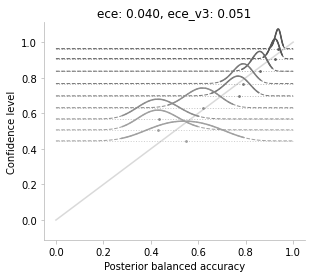

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75}, dpi=72)
ridge_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=15, metrics=[rmetrics.ece, rmetrics.ece_v3])

In [ ]:
# export

def class_wise_ridge_reliability_diagram(y_probs, y_preds, y_true, axes=None, bins="fd", plot_densities=True, metrics=[rmetrics.ece_v3], show_k_least_calibrated=None):
    
    classes = np.unique(y_true)
    
    if show_k_least_calibrated is None:
        show_k_least_calibrated = len(classes)
    
    plots = min(show_k_least_calibrated, len(classes))
    
    if axes is None:
        fig, axes = plt.subplots(1, plots, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72)
    assert len(axes) == plots, f"Wrong amount of axes provided: {plots} needed, but {len(axes)} provided."

    y_true_binarized = label_binarize(y_true, classes=classes)
    y_preds_binarized = label_binarize(y_preds, classes=classes)
        
    metric_values = []
    for c in classes:
        probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])
        metric_values.append([m(probs, y_preds_binarized[:, c], y_true_binarized[:, c]) for m in metrics])
    metric_values = np.array(metric_values)
    
    for ax, c in zip(axes, np.argsort(metric_values[:, 0])[::-1][:show_k_least_calibrated]):        
        probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])
        
        ax.set_title(f"Class {c}")
        _add_metrics_to_title(ax, metrics, probs, y_preds_binarized[:, c], y_true_binarized[:, c])
        
        ridge_reliability_diagram(probs, y_preds_binarized[:, c], y_true_binarized[:, c], ax, bins, plot_densities, exact=True)

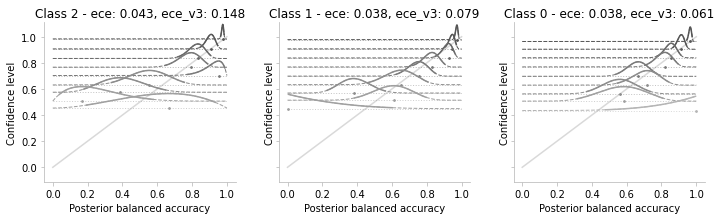

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=72, figsize=(10, 3))
class_wise_ridge_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, axes=axes, bins=15, metrics=[rmetrics.ece, rmetrics.ece_v3])

## Confidence reliability diagram

In [ ]:
# exporti

def bar_diagram(edges:np.array, bin_accuracies:np.array, bin_confidences:np.array, ax:axes.Axes):
    """Plot a bar plot confidence reliability diagram.
    
    Arguments:
    edges -- Edges of the probability bins
    bin_accuracies -- Accuracy per bin
    bin_confidences -- Average confidence of predictions in bin
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    """
    
    _decorate_ax(ax)

    ax.plot([0,1], [0,1], linestyle="--", color=cm.tab20c(16))

    for xi, yi, bi in zip(edges, bin_accuracies, bin_confidences):
        if bi is np.nan:
            continue
        if yi < 0:
            continue

        ax.bar(xi, yi, width=edges[1], align="edge", color=cm.tab20c(18), edgecolor=cm.tab20c(19), linewidth=2, zorder=0)
        if yi >= bi:
            bar = ax.bar(xi+edges[1]/2, np.abs(bi-yi), bottom=bi, width=edges[1]/4, align="center", color=cm.tab20c(17), zorder=1)
        else:
            bar = ax.bar(xi+edges[1]/2, np.abs(bi-yi), bottom=yi, width=edges[1]/4, align="center", color=cm.tab20c(17), zorder=1)

In [ ]:
# export

def confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, ax:axes.Axes, bins="fd", balanced:bool=True):
    """Plot a confidence reliability diagram.
    
    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """
    
    if len(y_probs.shape) == 2:
        if y_probs.shape[1] == 2:
            y_probs = y_probs[:, 0]
        else:
            y_probs = y_probs.max(axis=1)
    
    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    mean_confidences = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)
    bin_metric = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)
    
    metric = balanced_accuracy_score if balanced else accuracy_score
    
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Balanced accuracy" if balanced else "Accuracy")

    for bin_idx in unique_bin_indices:
        selector = bin_indices == bin_idx

        C = confusion_matrix(y_true[selector], y_preds[selector])
        with np.errstate(divide='ignore', invalid='ignore'):
            per_class = np.diag(C) / C.sum(axis=1)
        per_class = per_class[~np.isnan(per_class)]
        if len(per_class) < 2:
            continue

        mean_confidences[bin_idx-1] = np.mean(y_probs[selector])
        bin_metric[bin_idx-1] = metric(y_true[selector], y_preds[selector])

        bar_diagram(edges, bin_metric, mean_confidences, ax)

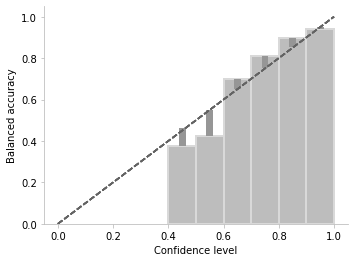

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10)

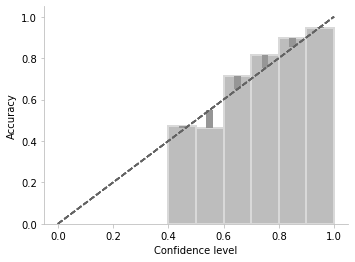

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10, balanced=False)

In [ ]:
# export

def class_wise_confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, axes:axes.Axes, bins="fd", balanced:bool=True):
    """Plot a class-wise confidence reliability diagram.
    
    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """
    
    classes = np.unique(y_true)

    y_true_binarized = label_binarize(y_true, classes=classes)
    y_preds_binarized = label_binarize(y_preds, classes=classes)
        
    for ax, c in zip(axes, range(len(classes))):
        ax.set_title(f"Class {c}")
        probs = np.where(y_preds_binarized[:, c]==0, 1-y_probs[:, c], y_probs[:, c])
        confidence_reliability_diagram(probs, y_preds_binarized[:, c], y_true_binarized[:, c], ax, bins, balanced)

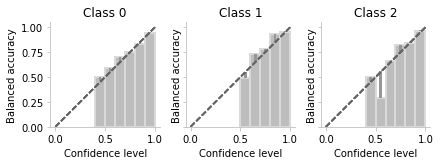

In [ ]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": 1}, constrained_layout=True, sharex=True, sharey=True)
class_wise_confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10)

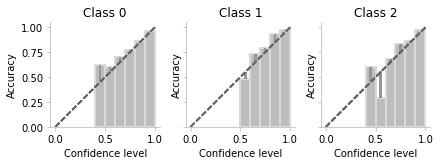

In [ ]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": 1}, constrained_layout=True, sharex=True, sharey=True)
class_wise_confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10, balanced=False)